## Taxi Orders

Our task is to attract more drivers during the peak period, and for this we need to predict the number of taxi orders for the next hour. We have historical data on taxi orders at the airports. We need to build a model for such a prediction so that the RMSE on the test sample is not greater than 48.

The project is divided into the following sections:  
[1. General information & resampling](#1)     
[2. Data analysis](#2)  
[3. Model Training](#3)  
[4. Summary](#4)  

### <a id="1">1. General information & resampling</a>

In [1]:
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.simplefilter('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from pandas.plotting import autocorrelation_plot
import time
import timeit

In [2]:
df=pd.read_csv('datasets/taxi.csv',index_col=[0], parse_dates=[0])

Number of orders is in the column 'num_orders'.

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


No missing values.

In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Min and Max are ok. We'll do resampling:

In [6]:
dfh = df.resample('1h').sum().sort_index()

In [7]:
dfh.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
dfh.index.is_monotonic

True

In [9]:
dfh.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [10]:
dfh.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

We checked that the data is in order from March 2018 to the end of August 2018 (6 months). Let's check the trend by month:

<AxesSubplot:xlabel='datetime'>

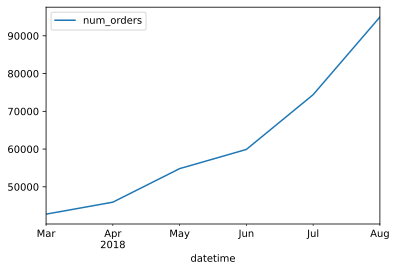

In [11]:
dfm=df.resample('1m').sum().sort_index()
dfm.plot()

The number of orders is growing every month and almost doubles in 6 months.

There are no missing values. We resampled one hour at a time and looked at the general trend that the number of orders is growing.

### <a id="2">2. Data analysis</a>

In [12]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=80):
    plt.figure(figsize=(12,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

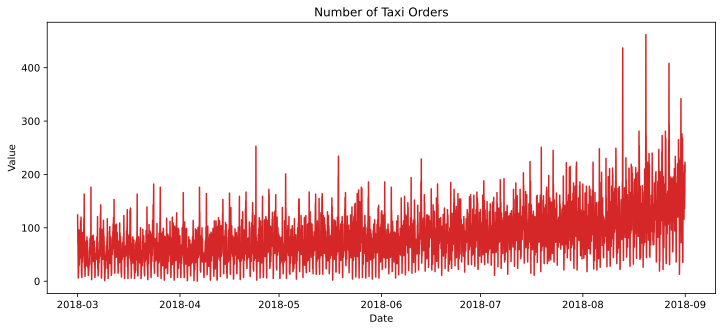

In [13]:
plot_df(dfh, x=dfh.index, y=dfh['num_orders'], title='Number of Taxi Orders')    

To reduce fluctuations in the time series, we use a moving average. Also we'll check the moving standard deviation.

<AxesSubplot:xlabel='datetime'>

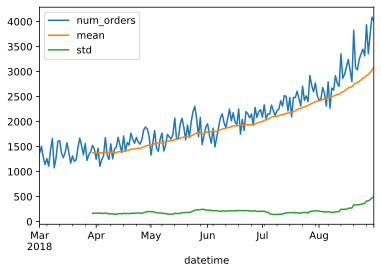

In [14]:
dfd = df.resample('1D').sum()
dfd['mean'] = dfd['num_orders'].rolling(30).mean()
dfd['std'] = dfd['num_orders'].rolling(30).std()
dfd.plot() 

To better understand the time series we need to look at seasonality. Function seasonal_decompose() takes the time series and gives back DecomposeResult.

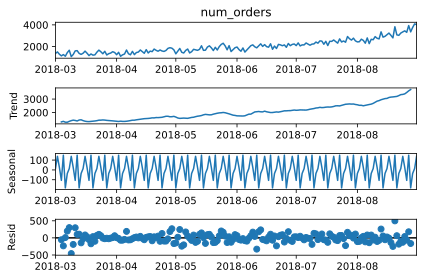

In [15]:
decompose = seasonal_decompose(dfd['num_orders'], period=7)
decompose.plot()
plt.show()

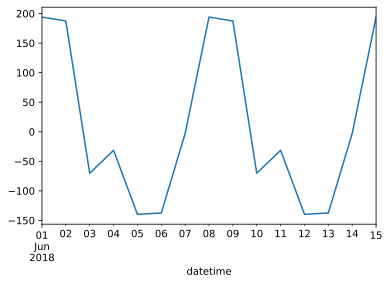

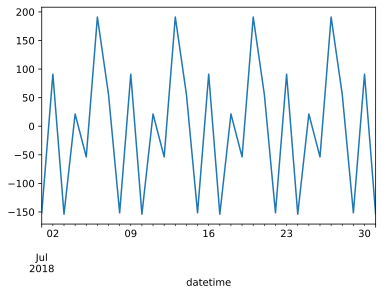

In [16]:
decompose_data = seasonal_decompose(dfd['num_orders']['2018-06-01':'2018-06-15'], model="additive").seasonal
decompose_data.plot()
plt.show()
decompose_data = seasonal_decompose(dfd['num_orders']['2018-07-01':'2018-07-31'], model="additive").seasonal
decompose_data.plot()
plt.show()

More orders on the weekend than at the end of the week.

### Autocorrelation


Autocorrelation measures the linear relationship between lagged values of a time series.

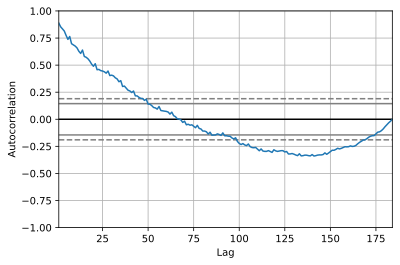

In [17]:
autocorrelation_plot(dfd['num_orders'])
plt.show()

Method plot_acf in statsmodels is used to show the autocorrelation visual.

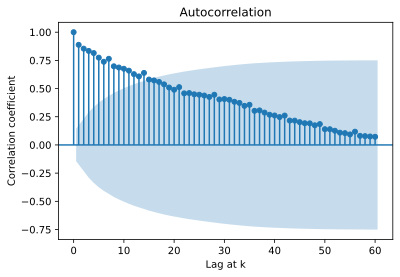

In [18]:
fig = tsaplots.plot_acf(dfd['num_orders'], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

The vertical axis represents the autocorrelation coefficient and we see that it approaches zero.

We will perform Augmented Dickey-Fuller Test to check the stationarity.

Stationarity is a key part of time series analysis. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. You should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

### Augmented Dickey-Fuller Test
This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity.

In [19]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries, autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [20]:
ADF_test(dfh["num_orders"].values,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.069
P-value = 0.029
Critical values :
	1%: -3.431842162413052 - The data is not stationary with 99% confidence
	5%: -2.8621993540813637 - The data is  stationary with 95% confidence
	10%: -2.567120978470452 - The data is  stationary with 90% confidence


The null hypothesis (H0) and alternative hypothesis (H1) of ADF are as following:
H0: has unit roots and belongs to the non-stationary series.
H1: There is no unit root and belongs to a stationary sequence, indicating that this sequence has no temporal structure.

Based on the standard score value of 0.05, the p-value is much less than 0.05, indicating that the null hypothesis is not supported, indicating that we have a stationary series. H1: There is no unit root and belongs to a stationary sequence, which indicates that this sequence has no temporal structure.

### <a id="3">3. Model Training</a>

Function make_features() will add 4 new features: year, month, day and day of the week.

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(lag).mean()

In [22]:
make_features(dfh, 6,6)
print(dfh)

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   
...                         ...    ...  ...        ...   ...    ...    ...   
2018-08-31 19:00:00         136      8   31          4    19  207.0  217.0   
2018-08-31 20:00:00         154      8   31          4    20  136.0  207.0   
2018-08-31 21:00:00         159      8   31          4    21  154.0  136.0   
2018-08-31 22:00:00         223      8   31          4    22  159.0  154.0   
2018-08-31 23:00:00         205      8   31          4    23  22

In [23]:
dfh.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


Lets divide the dataset into train and test sets. 

In [24]:
train, test = train_test_split(dfh, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
train = train.dropna()

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [25]:
train_target=train['num_orders']
train_features=train.drop(['num_orders'],axis=1)
test_target=test['num_orders']
test_features=test.drop(['num_orders'],axis=1)

We will look at the following models:
    1) Linear Regression  
    2) Random Forest Regression  

Table that can support final decision:

In [26]:
eval_table = {"models": ["linear_regr","random_forest_regr"], "rmse": [0.0]*2,"time_model": [0.0]*2,"time_predict": [0.0]*2}
eval_table=pd.DataFrame(eval_table)
print(eval_table)

               models  rmse  time_model  time_predict
0         linear_regr   0.0         0.0           0.0
1  random_forest_regr   0.0         0.0           0.0


## Linear Regression

In [27]:
start = time.time()
reg = LinearRegression().fit(train_features, train_target)
mid = time.time()
pred_test = reg.predict(test_features)
end = time.time()
time_model=mid-start
time_predict=end-mid
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(test_target, pred_test))))
print(time_model)
print(time_predict)

RMSE: 53.100
0.004910945892333984
0.0009682178497314453


In [28]:
eval_table["rmse"].values[0] = np.sqrt(mean_squared_error(test_target, pred_test))
eval_table["time_model"].values[0] = time_model
eval_table["time_predict"].values[0] = time_predict
eval_table

,models,rmse,time_model,time_predict
0,linear_regr,53.099755,0.004911,0.000968
1,random_forest_regr,0.000000,0.000000,0.000000


## Random Forest Regressor

In [29]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

In [ ]:
start = time.time()
param_grid = {
    "n_estimators": [10, 25, 50, 100],
    "max_depth": [2, 4, 8, 10,12,14],
"min_samples_split": [2,4,6,8],
"min_samples_leaf":[1,2]}
model = RandomForestRegressor(random_state = 12345)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, scoring="neg_mean_squared_error", cv=tscv).fit(train_features, train_target)
best_params = grid_search.best_params_
model=RandomForestRegressor(**best_params).fit(train_features, train_target)
mid = time.time()
pred_test = model.predict(test_features)
end = time.time()
time_model=mid-start
time_predict=end-mid
print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(test_target, pred_test))))
print(time_model)
print(time_predict)

RMSE: 45.580
754.4726898670197
0.007050037384033203


In [ ]:
eval_table["rmse"].values[1] = np.sqrt(mean_squared_error(test_target, pred_test))
eval_table["time_model"].values[1] = time_model
eval_table["time_predict"].values[1] = time_predict
eval_table

# <a id="4">4. Summary</a>

Our task was to predict the number of taxi orders for the next hour, having historical data. We tested the time series analysis for trends, seasonality, and stationarity. We have noticed that the number of taxi orders is growing, increasing on weekends and decreasing during the week. We considered 2 models and changed the parameters to find the best prediction result. We chose RandomForestRegressor for prediction since RMSE is less than 48 (we got 44.948) and algorithm time was normal. We could consider other models to improve the prediction, such as Arima.